<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Описание данных

Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»).

Признаки

- RowNumber — индекс строки в данных 
- CustomerId — уникальный идентификатор клиента 
- Surname — фамилия 
- CreditScore — кредитный рейтинг 
- Geography — страна проживания Gender — пол 
- Age — возраст 
- Tenure — количество недвижимости у клиента 
- Balance — баланс на счёте 
- NumOfProducts — количество продуктов банка, используемых клиентом 
- HasCrCard — наличие кредитной карты 
- IsActiveMember — активность клиента 
- EstimatedSalary — предполагаемая зарплата Целевой признак 
- Exited — факт ухода клиента

## Подготовка данных

In [1]:
#Подключим все необходимые библиотеки для нашего проекта

import numpy as np
import pandas as pd 
import IPython
from IPython.display import display
import re
import warnings
warnings.simplefilter('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.metrics import  (
    accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, precision_score,
    recall_score)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
#Загрузим файл и Посмотрим как выглядит датасет
data = pd.read_csv('/datasets/Churn.csv')
display(data.head(5))
display(data.tail(5))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


Первые три столбца (номер, id и фамилия клиента, никак не повлияют на принятие решения по уходу из банка, и их можно будет удалить из датасета для ускориния работы кода.

In [3]:
data = data.iloc[:,3:]
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Преобразуем имена колонок

In [4]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in data.columns]
data

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [6]:
#Имеются ли пустые значения в датасете
data.isnull().sum()

credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

В колонке с количеством лет обслуживания в банке есть пропуски. Типы данных в таблице указаны верно.посмотрим уникальные значения.

In [7]:
data.tenure.unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [8]:
print('Пропущенных значений в признаке tenure: {:.2%}'.format(data['tenure'].isnull().sum()/data['tenure'].shape[0]))

Пропущенных значений в признаке tenure: 9.09%


Как видно, дробных значений в столбце Tenure не найдено, следовательно, можно спокойно менять тип данных на 
целочисленный и заменить пропущенные значения на 0, так как существует вероятность, что клиент с со значением nan 
обслуживается банком менее года

In [11]:
data = data.fillna(0)

In [13]:
#Посмотрим имеются ли у нас дубликаты 
data.duplicated().sum()

0

Дубликатов нет.

Посмотрим статистику по числовым данным датасета:

In [14]:
data.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.543400,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,3.111573,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


В среднем на счетах клиентов находится сумма ~ 76485.89 EUR;
Средняя предполагаемая зарплата ~ 100090.24 EUR;
Активных пользователей банковских услуг не менее 51.5% от общего числа клиентов;
Средний возраст клиентов банка - 39 лет. Самый возрастной клиент банка - 92 года;
В среднем люди пользуются банковскими услугами 4 года;
Большая часть клиентов банка владеет кредитной картой - более 70%;
В банке больше лояльных клиентов, чем ушедших (75% перцентиль = 0)

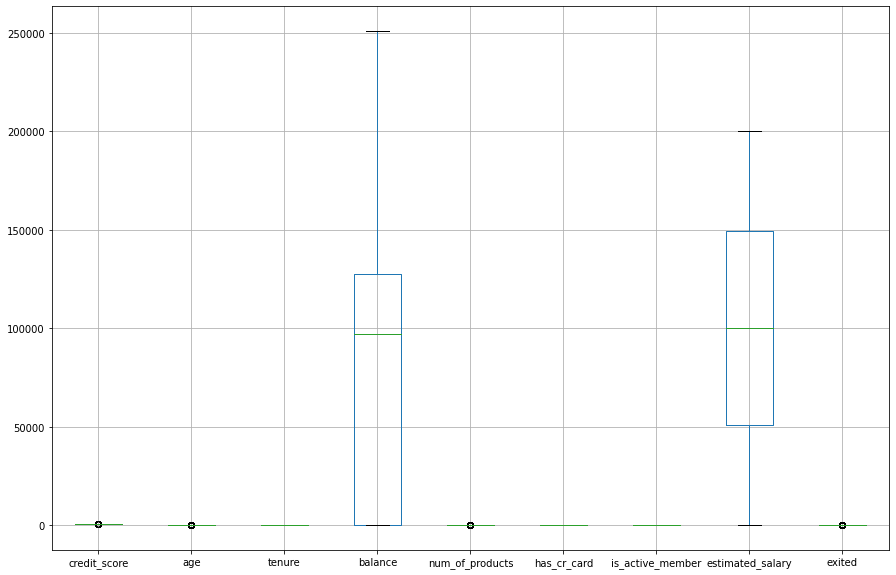

In [15]:
data[['credit_score','age','tenure','balance','num_of_products','has_cr_card','is_active_member','estimated_salary','exited'
     ]].boxplot(figsize=(15,10));

Выбросы не наблюдаются

In [16]:
#Посмотрим на таблицу корреляции
data.corr()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.003965,0.003087,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.007368,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,0.003087,-0.007368,1.000000,-0.005821,0.010106,0.021387,-0.025856,0.011225,-0.013319
balance,0.006268,0.028308,-0.005821,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.012238,-0.030680,0.010106,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_cr_card,-0.005458,-0.011721,0.021387,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.025651,0.085472,-0.025856,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.011225,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.013319,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


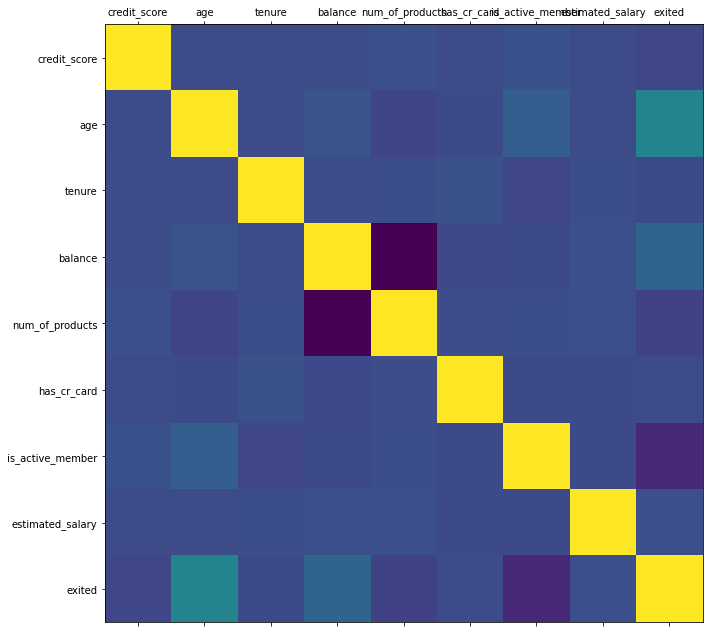

In [17]:
#Посмотрим на табличный график матрицы корреляции
def plot_corr(data, size=11):
  corr = data.corr()
  fig, ax = plt.subplots(figsize=(size,size))
  ax.matshow(corr)
  plt.xticks(range(len(corr.columns)), corr.columns)
  plt.yticks(range(len(corr.columns)), corr.columns)

plot_corr(data)

Сильных корреляционных связей не замечено.

Кодирование данных:

In [18]:

data = pd.get_dummies(data, drop_first=True)
data.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary', 'exited',
       'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')

In [19]:
data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [20]:
data.describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  float64
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [21]:
data

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


In [22]:
#Процент ушедших и оставшихся клиентов за все время.

data['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

In [23]:
train, test = train_test_split(data, test_size=0.2, random_state=12345, stratify=data['exited'])

Не сбалансиовнный целевой признак в выборке

Первый предварительный вывод: статистически клиент может покинуть банк в 20% случаев.

In [24]:
#С помощью train_test_split Разделим датасет на следующие выборки 

features = data.drop(['exited'], axis=1)
target = data['exited']

#features_train, features_valid, target_train, target_valid = train_test_split(features, target, train_size=0.6, test_size=0.4, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                target, test_size=0.2, random_state=12345, stratify=target)
features_test, features_valid, target_test, target_valid = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

print('Training set size:', features_train.shape[0])
print('Validating set size:', features_valid.shape[0])
print('Test set size:',features_test.shape[0])

Training set size: 8000
Validating set size: 1000
Test set size: 1000


In [25]:
numeric_column = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 
                 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric_column])

features_train[numeric_column] = scaler.transform(features_train[numeric_column])
features_valid[numeric_column] = scaler.transform(features_valid[numeric_column])

## Исследование задачи

In [26]:
model_score = pd.DataFrame(columns=['model_name', 'f1', 'auc_roc'])


def print_and_add(df, name, f1, auc_roc): # вывод показателей и запись их в таблицу
    print('best F1: {:.3f}'.format(f1))
    print('best AUC-ROC: {:.3f}'.format(auc_roc))
    return df.append({'model_name' : name, 'f1': f1, 'auc_roc': auc_roc},
                              ignore_index=True)

In [27]:
best_c = 0
best_auc_roc = 0
best_f1 = 0

for c in np.arange(0.03, 0.045, 0.001):
    model = LogisticRegression(random_state=12345, C=c, solver='liblinear')
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted)
    if f1 > best_f1:
        best_f1 = f1
        best_c = c
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one)
print('best C: {:.2f}'.format(best_c))        
model_score = print_and_add(model_score, 'LogisticRegression', best_f1, best_auc_roc)

best C: 0.04
best F1: 0.279
best AUC-ROC: 0.782


In [28]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
for depth in trange(11,15):    
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted) 
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', depth)

model_score = print_and_add(model_score, 'DecisionTreeClassifier', best_f1, best_auc_roc)

  0%|          | 0/4 [00:00<?, ?it/s]

best depth: 14
best F1: 0.555
best AUC-ROC: 0.752


In [29]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
best_est = 0

for est in trange(157, 160):    
    for depth in range(12,15):    
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted) 
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
            probabilities = model.predict_proba(features_valid)
            probabilities_one = probabilities[:,1]
            best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', best_depth)
print('best n_estimators:', est)
model_score = print_and_add(model_score, 'RandomForestClassifier', best_f1, best_auc_roc)

  0%|          | 0/3 [00:00<?, ?it/s]

best depth: 12
best n_estimators: 159
best F1: 0.539
best AUC-ROC: 0.869


Вывод

На первом этапе были произведены анализ и предобработка данных.

В ходе указанных действий датасет был очищен он лишних столбцов, данные были приведены в требуемый вид, пропуски заполнены в соответсвии с логическими заключениями.

Данные были перведены в требуемый вид с помощью команды get_dummy.

Численные признаки масштабированы с помощью StandardScaler.

Датасет был разбит на три выборки с целью обучения, валидации и тестирования моделей.

Сделан первый предварительный вывод: статистически клиент может покинуть банк в 20% случаев.


## Борьба с дисбалансом

In [30]:
data['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

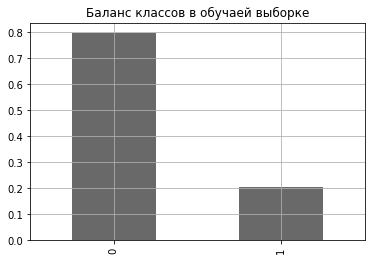

In [31]:
data.exited.value_counts(normalize=True).plot(kind='bar', color='dimgray', grid=True)
plt.title('Баланс классов в обучаей выборке')
plt.show()

Не сбалансированный целевой признак в выборке.

Попробуем убрать дисбаланс с помощью аргумента class_weight

In [32]:
balanced_model_score = pd.DataFrame(columns=['model_name', 'f1', 'auc_roc'])

In [33]:
best_c = 0
best_auc_roc = 0
best_f1 = 0

for c in np.arange(0.03, 0.05, 0.001):
    model = LogisticRegression(random_state=12345, C=c, solver='liblinear',
                               class_weight='balanced')
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted)
    if f1 > best_f1:
        best_f1 = f1
        best_c = c
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one)
print('best C:', best_c)        
balanced_model_score = print_and_add(balanced_model_score, 'LogisticRegression',
                                     best_f1, best_auc_roc)

best C: 0.032
best F1: 0.519
best AUC-ROC: 0.788


In [34]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
for depth in trange(8,15):    
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted) 
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', depth)
balanced_model_score = print_and_add(balanced_model_score, 'DecisionTreeClassifier',
                                     best_f1, best_auc_roc)

  0%|          | 0/7 [00:00<?, ?it/s]

best depth: 14
best F1: 0.586
best AUC-ROC: 0.811


In [35]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
best_est = 0

for est in trange(155, 160):    
    for depth in range(5,13):    
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est,
                                       class_weight='balanced')
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted) 
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
            probabilities = model.predict_proba(features_valid)
            probabilities_one = probabilities[:,1]
            best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', best_depth)
print('best n_estimators:', est)
balanced_model_score = print_and_add(balanced_model_score, 'RandomForestClassifier',
                                     best_f1, best_auc_roc)

  0%|          | 0/5 [00:00<?, ?it/s]

best depth: 8
best n_estimators: 159
best F1: 0.647
best AUC-ROC: 0.870


(array([0, 1, 2]),
 [Text(0, 0, 'LogisticRegression'),
  Text(1, 0, 'DecisionTreeClassifier'),
  Text(2, 0, 'RandomForestClassifier')])

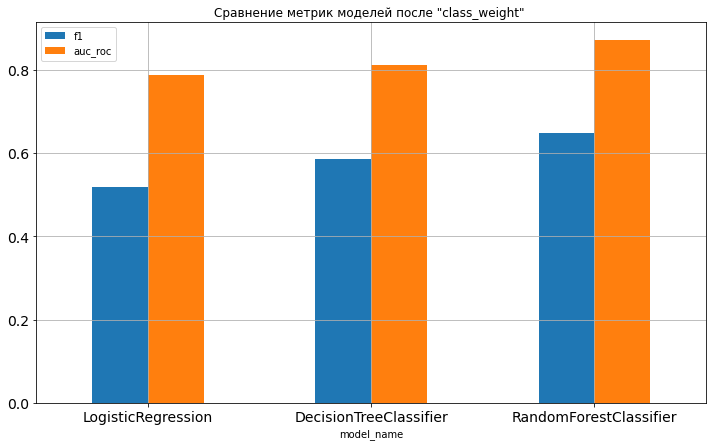

In [36]:
balanced_model_score.plot(x='model_name', kind='bar', figsize=(12,7), fontsize=14, grid=True,
                          title='Сравнение метрик моделей после "class_weight" ' )
plt.xticks(rotation=0)

Увеличим количество положительных целевых признаков в 4 раза (примерно уравняем его с количеством отрицательных 
целевых признаков).

In [37]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled,
                                                   random_state=12345)
    return features_upsampled, target_upsampled

In [38]:
features_train, target_train = upsample(features_train, target_train, 4)
target_train.value_counts(normalize=True)

1    0.505818
0    0.494182
Name: exited, dtype: float64

Классы практически сравнялись

In [39]:
upsample_model_score = pd.DataFrame(columns=['model_name', 'f1', 'auc_roc'])

In [40]:
best_c = 0
best_auc_roc = 0
best_f1 = 0

for c in np.arange(0.03, 0.05, 0.001):
    model = LogisticRegression(random_state=12345, C=c, solver='liblinear')
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted)
    if f1 > best_f1:
        best_f1 = f1
        best_c = c
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one)
print('best C:', best_c)        
upsample_model_score = print_and_add(upsample_model_score, 'LogisticRegression',
                                     best_f1, best_auc_roc)

best C: 0.03
best F1: 0.517
best AUC-ROC: 0.788


In [41]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
for depth in trange(8,15):    
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted) 
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        probabilities = model.predict_proba(features_valid)
        probabilities_one = probabilities[:,1]
        best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', depth)

upsample_model_score = print_and_add(upsample_model_score, 'DecisionTreeClassifier',
                                     best_f1, best_auc_roc)

  0%|          | 0/7 [00:00<?, ?it/s]

best depth: 14
best F1: 0.587
best AUC-ROC: 0.809


In [42]:
best_f1 = 0
best_depth = 0
best_auc_roc = 0
best_est = 0

for est in trange(155, 160):    
    for depth in range(5,13):    
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted) 
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_est = est
            probabilities = model.predict_proba(features_valid)
            probabilities_one = probabilities[:,1]
            best_auc_roc = roc_auc_score(target_valid, probabilities_one) 
print('best depth:', best_depth)
print('best n_estimators:', est)
upsample_model_score = print_and_add(upsample_model_score, 'RandomForestClassifier',
                                     best_f1, best_auc_roc)

  0%|          | 0/5 [00:00<?, ?it/s]

best depth: 8
best n_estimators: 159
best F1: 0.632
best AUC-ROC: 0.869


(array([0, 1, 2]),
 [Text(0, 0, 'LogisticRegression'),
  Text(1, 0, 'DecisionTreeClassifier'),
  Text(2, 0, 'RandomForestClassifier')])

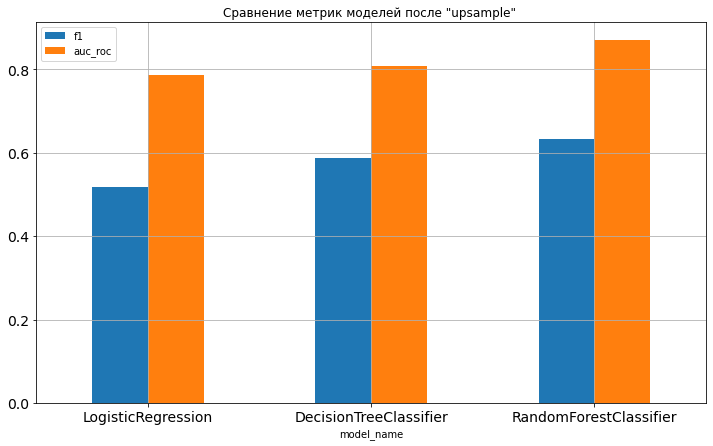

In [43]:
upsample_model_score.plot(x='model_name', kind='bar', figsize=(12,7), fontsize=14, grid=True,
                          title='Сравнение метрик моделей после "upsample" ' )
plt.xticks(rotation=0)

In [44]:
model_score # Не сбалансированная выборка

,model_name,f1,auc_roc
0,LogisticRegression,0.279412,0.781621
1,DecisionTreeClassifier,0.554974,0.752420
2,RandomForestClassifier,0.539185,0.868776


In [45]:
balanced_model_score # Балансировка "class_weight"

,model_name,f1,auc_roc
0,LogisticRegression,0.518519,0.787752
1,DecisionTreeClassifier,0.586011,0.811371
2,RandomForestClassifier,0.646809,0.869711


In [46]:
upsample_model_score # Балансировка "upsample"

,model_name,f1,auc_roc
0,LogisticRegression,0.516667,0.787541
1,DecisionTreeClassifier,0.587332,0.809231
2,RandomForestClassifier,0.632411,0.869277


Оба метода балансировки выборки существенно улучшили показатели рассмотренных моделей. 
Лучшие показатели при балансировке у модели RandomForestClassifier, худшие у модели LogisticRegression. 

## Тестирование модели

Предобработка тестовых данных

Преобразование категориальных признаков с помощью OHE

In [47]:
test = pd.get_dummies(test, drop_first=True)

Масштабирование численных признаков

In [49]:
numeric_column = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 
                 'estimated_salary']

scaler = StandardScaler()


scaler.fit(features_train[numeric_column])

features_train[numeric_column] = scaler.transform(features_train[numeric_column])
features_test[numeric_column] = scaler.transform(features_test[numeric_column])

Обучение лучшего по исследованию алгоритма "Случайный лес"

In [50]:
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=159,
                               class_weight='balanced')
model.fit(features, target)
predicted = model.predict(features_test)

In [51]:
print('F1: {:,.3f}'.format(f1_score(target_test, predicted)))
probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:,1]
print('AUC_ROC: {:,.3f}'.format(roc_auc_score(target_test, probabilities_one)))
print('Accuracu: {:,.3f}'.format(model.score(features_test, target_test)))
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_one)


F1: 0.706
AUC_ROC: 0.920
Accuracu: 0.872


In [52]:
rf_fin = RandomForestClassifier(random_state=2202, max_depth=9, n_estimators=159).fit(features_test, target_test)

In [53]:
def roc_curve_plot(model, name):
    
    p_test = model.predict_proba(features_test)
    p_one_test = p_test[:, 1]
    
    auc_roc = roc_auc_score(target_test, p_one_test)

    fpr, tpr, thresholds = roc_curve(target_test, p_one_test)

    plt.figure(figsize=(5,3))

    plt.plot(fpr, tpr, color='mediumblue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='firebrick')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая модели {}'.format(name))
    
    plt.show()
    print('AUC-ROC модели {} = {:.3}'.format(name, auc_roc))

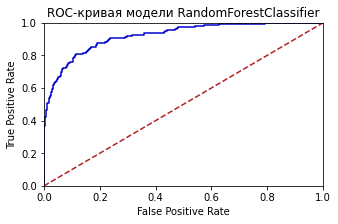

AUC-ROC модели RandomForestClassifier = 0.92


In [54]:
roc_curve_plot(model, 'RandomForestClassifier')

Итог - f1_score случайного леса с заданными параметрами на тестовой выборке ~0.0.706, что на текущий момент является лучшим результатом.
Accuracu нашей модели практически 87.2%. Площадь под кривой ошибок так же продемонстрировала лучший за всю историю наблюдений показатель ~0.936.

# Общий вывод
